# NTDS assignment 3: spectral graph theory
[Michaël Defferrard](http://deff.ch), *PhD student*, [EPFL LTS2](http://lts2.epfl.ch)

The first two assignments were designed to warm you up. This third assignment is closer to what we expect you to do for the projects. It mainly misses the exploratory data analysis part (though there is some in sections 5.1 and 5.2). As such, our plan for this assignement encompasses data collection and exploitation, and goes as follows:
1. Data collection: use a web API to collect the musical genre of 2000 songs.
2. Feature extraction: compute features from audio tracks.
3. Graph construction: construct a nearest-neighbor graph from the features.
4. Eigendecomposition: factorization of the graph Laplacian (c.f. spectral graph theory).
5. Visualization & Clustering: using the graph and eigenvectors to visualize the dataset and to cluster the tracks.
6. Conclusion: a reflexion about what we did (though realisations are scattered all along).

The data we are using for this assignment is a subset of the [Free Music Archive dataset](https://github.com/mdeff/fma), a collection of 1TB of music with metadata released under a permissive license.

In [1]:
%matplotlib inline

import configparser
import os

import requests
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
from sklearn import preprocessing, decomposition
import librosa
import IPython.display as ipd

plt.rcParams['figure.figsize'] = (17, 5)

If the above cell fails, it's most probably because you miss a package. Install them with e.g. `conda install tqdm librosa` (or `pip install tqdm librosa`).

## 1 Data collection

Like in any data project, the first part of the assignment is to collect some data. 

### 1.1 Get the genre of a single track

As often, we need an API key for certain operations. Add the following to your `credentials.ini` file. I gave a key during the lab on November 6. If you were not there, ask one of your classmates. Please do not over-use the key (it'll otherwise be banned for everybody).
```
[freemusicarchive]
api_key = MY-KEY
```

In [2]:
# Read the confidential API key.
credentials = configparser.ConfigParser()
credentials.read(os.path.join('..', 'credentials.ini'))
api_key = credentials.get('freemusicarchive', 'api_key')

Your first task is to develop a function to retrieve the genre ID of a track given its track ID using the [FMA API](https://freemusicarchive.org/api).

Hints:
* A track might have multiple genres associated to it. Always return the first one and discard the others.
    * Note: you should never discard data blindly. I selected the tracks so that this is not a problem.
* The `get_genre` function takes an integer as input, the track ID, and returns another integer, the genre ID.

In [3]:
def get_genre(track_id):
    """Returns the genre of a track by querying the API."""
    BASE_URL = 'https://freemusicarchive.org/api/get/tracks.json' 
    url = '{}?track_id={}&api_key={}'.format(BASE_URL, track_id, api_key) 
    response = requests.get(url).json() 
    return int (response['dataset'][0]['track_genres'][0]['genre_id']) 

print(get_genre(1219))

# A correct implementation should pass the below test.
assert get_genre(1219) == 38

38


### 1.2 Create a table of tracks

The `fma_tracks.csv` file contains a list of 2'000 track IDs that we will use through the assignment.

In [4]:
tracks = pd.read_csv('../data/fma_tracks.csv', index_col=0)
print('You got {} track IDs.'.format(len(tracks)))

You got 2000 track IDs.


Once imported by pandas, each row of the DataFrame represents a track. The index is the track ID and the genre column is the genre ID of each track.

In [5]:
tracks.iloc[125:130]

,genre
track_id,
11204,21
11264,88
11268,89
11298,21
11299,21


### 1.3 Add the genre to the table

The genre column contains an integer which represents the genre of the track, i.e. the return value of the `get_genre` function you developed. Because I'm a nice guy, I retrieved the genre for most tracks. Only the genre of the first 10 tracks is missing (zero is a placeholder value).

In [6]:
tracks.head(10)

,genre
track_id,
2,0
5,0
182,0
255,0
256,0
368,0
459,0
574,0
676,0


Your task is to replace the 10 zeros with the correct genre IDs.

Hints:
* As we want to apply one function (`get_genre`) to many data samples (the track IDs), you may want to use a functional approach. Check out `tracks.apply()` or the built-in `map`. In Python, you can declare an [anonymous function](https://en.wikipedia.org/wiki/Anonymous_function) as `lambda x: x + 1`.
* Your table should look like the above table, except with the correct number instead of zeros.

In [7]:
tracks.iloc[:10, 0] = tracks.head(10).apply(lambda x: get_genre(x.name), axis = 1)

In [8]:
#tracks.head(10)

### 1.4 Save the data

To avoid having to collect the data everytime you restart the IPython kernel, save the DataFrame as a CSV file.

In [9]:
tracks.to_csv('../data/fma_tracks_with_genre.csv')

You can now load it back with the following call instead of running the code in sections 1.1 to 1.3.

In [10]:
tracks = pd.read_csv('../data/fma_tracks_with_genre.csv', index_col=0)

### 1.5 Data cleaning

Data cleaning is necessary when dealing with real (as opposed to synthetic) data. In this case, we only need to "summarize the genres". The tracks I've selected for the assignment belong to either one of the following *top-level genres*: Rock (`genre_id=12`) and Hip-Hop (`genre_id=21`). There *actual genre(s)* might however be more specific and be a sub-genre of those. For example Punk is a sub-genre of Rock. You can explore the genre hierarchy on the [Free Music Archive](http://freemusicarchive.org/genre/Rock/). The below function will return the correct top-level genre for any of the sub-genres you'll encounter.

In [11]:
def get_top_genre(genre_id):
    if genre_id == 0:
        raise ValueError('Invalid genre! Please complete the DataFrame.')
    else:
        return 21 if genre_id in [21, 83, 100, 539, 542, 811] else 12

tracks = tracks.applymap(lambda genre: get_top_genre(genre))
tracks.head(4)

,genre
track_id,
2,21
5,21
182,12
255,12


If everything went fine, you should now have 1000 Rock (`genre_id=12`) and 1000 Hip-Hop (`genre_id=21`) tracks.

In [12]:
tracks['genre'].value_counts()

21    1000
12    1000
Name: genre, dtype: int64

## 2 Feature extraction

As is often the case, the data at hand is too large to be dealt with directly. We have to represent it with a smaller set of features, chosen to be maximally relevant to the task. (Manual feature extraction can sometimes be replaced by end-to-end learning systems.)

### 2.1 Get raw data

In the data folder, you'll find audio excerpts for the first 10 tracks listed in the `tracks` table. The audio is encoded as mp3 and the filename is simply the track ID.

[LibROSA](https://librosa.github.io/librosa/) is a well-designed Python package to deal with music data, i.e. to load audio, compute spectrograms and extract features. Let's use it and listen to some music. 

In [13]:
def get_path(track_id):
    return os.path.join('..', 'data', '{:06d}.mp3'.format(track_id))

# 1. Get the path to the first file.
filepath = get_path(tracks.index[0])
print('File: {}'.format(filepath))

# 2. Decode the mp3 and load the audio in memory.
audio, sampling_rate = librosa.load(filepath, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(audio.shape[-1] / sampling_rate, audio.size))

# 3. Load the audio in the browser and play it.
start, end = 7, 17
ipd.Audio(data=audio[start*sampling_rate:end*sampling_rate], rate=sampling_rate)

File: ..\data\000002.mp3
Duration: 29.98s, 1321967 samples


If the above cell fails with a `NoBackendError`, it's most probably because you need an mp3 decoder that [audioread](https://github.com/beetbox/audioread) can call. Try to install ffmpeg with e.g. `conda install ffmpeg`.

### 2.2 Audio features

For music, the [mel-frequency cepstral coefficients (MFCCs)](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) are often relevant spectral features. Complete the implementation of the `compute_mfcc` function, which takes a track ID as its sole parameter and returns the coefficients.

Hint:
* Use the function `librosa.feature.mfcc` to compute those features.

In [14]:
N_MFCC = 20

def compute_mfcc(track_id):
    filepath = get_path(track_id)
    audio, sampling_rate = librosa.load(filepath, sr=None, mono=True)
    coeff = librosa.feature.mfcc(y=audio, sr=sampling_rate, S=None, n_mfcc=N_MFCC)
    return coeff

mfcc = compute_mfcc(tracks.index[0])
assert mfcc.ndim == 2
assert mfcc.shape[0] == N_MFCC

mfcc.shape

(20, 2582)

### 2.3 Summary statistics

The `compute_mfcc` function we developed above computes `N_MFCC` coefficients per window in time. Notice that we computed `N_MFCC` x 2582 coefficients for the first track. To have a fixed representation for each complete track (and not for each window of 2048 samples), we need to aggregate those coefficients along time. We'll do it with 7 summary statistics: the minimum, the maximum, the median, and the first 4 moments, i.e. the mean, the standard deviation, the skew and the kurtosis.

Below, we construct the DataFrame that will hold our features. (Note the use of a hierarchical index.) Again, I computed the features for most tracks.

In [15]:
features = pd.read_csv('../data/fma_features.csv', index_col=0, header=[0, 1, 2])
assert (tracks.index == features.index).all()

features.tail(4)

features        mfcc                                                    \
statistics  kurtosis                                                     
number            01        02        03        04        05        06   
track_id                                                                 
154307     -0.120522  0.522564  0.772077 -0.631063 -0.439495 -0.579385   
154308      0.486471  2.039885  1.065340  1.553311  1.149207  1.233508   
154309     -0.000699 -0.664378  1.479098  0.647598  0.688074  1.628477   
155066      4.009223  2.374810  3.122061  0.323748  0.175242  0.158041   

features                                              ...                \
statistics                                            ...           std   
number            07        08        09        10    ...            11   
track_id                                              ...                 
154307     -0.435570 -0.253491 -0.057322 -0.178522    ...     11.143944   
154308      0.740646 -0.296303  0.002152  0.429307    ...      8.949037   
154309      0.819533 -0.440711 -0.458720 -0.618500    ...     11.229300   
155066      0.265011 -0.089093 -0.031688  0.431877    ...     11.405719   

features                                                                    \
statistics                                                                   
number             12         13         14         15        16        17   
track_id                                                                     
154307       9.791041   9.071079   9.473701   8.991920  8.465207  7.609439   
154308       6.971979   7.353863   7.962605   7.378716  7.031327  6.790538   
154309      11.016286   8.687562   8.560948   8.519457  7.922051  7.243402   
155066      10.899215  10.969735  11.738620  11.327765  9.786315  8.778796   

features                                   
statistics                                 
number            18         19        20  
track_id                                   
154307      8.693686  11.166705  9.853825  
154308      6.708085   7.647438  7.791453  
154309      7.598657   7.149076  8.686818  
155066      9.148952   8.944389  8.137584  

[4 rows x 140 columns]

Though I forgot to compute them for the first 10 tracks. ;-) Complete the below code to do that.

Hints:
* Functions to compute the mentioned statistics are found in `np` and `stats` (from `scipy`, see imports).
* We use `tqdm` to show progress on long computations. For example: `for i in tqdm(range(10)): print(i)`.

In [16]:
for tid in tqdm(tracks.index[:10]):
    mfcc = compute_mfcc(tid)
    features.at[tid, ('mfcc', 'mean')] = np.mean(mfcc, axis=1) 
    features.at[tid, ('mfcc', 'std')] = np.std(mfcc, axis=1) 
    features.at[tid, ('mfcc', 'skew')] = scipy.stats.skew(mfcc, axis=1) 
    features.at[tid, ('mfcc', 'kurtosis')] = scipy.stats.kurtosis(mfcc, axis=1) 
    features.at[tid, ('mfcc', 'median')] = np.median(mfcc, axis=1) 
    features.at[tid, ('mfcc', 'min')] = np.min(mfcc, axis=1) 
    features.at[tid, ('mfcc', 'max')] = np.max(mfcc, axis=1) 

features['mfcc','mean'].head(4)
#features.head(4)

100%|██████████████████████████████████████████| 10/10 [00:03<00:00,  2.70it/s]


number,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20
track_id,,,,,,,,,,,,,,,,,,,,
2,-122.712340,117.759397,-42.334596,38.060242,-23.011659,23.920413,-11.944656,13.687301,-7.294474,4.041134,-4.857005,-1.660614,-6.305957,-2.195009,1.731766,-0.433247,6.396583,-3.303581,1.283125,-5.927941
5,-162.232688,131.441883,-18.427922,51.634278,-15.447669,23.863670,-7.870194,10.688036,-0.314265,12.865315,-9.883394,0.066135,0.767982,2.769372,9.108076,1.641228,8.163592,-1.507941,1.992454,-4.972336
182,-109.799454,220.001599,-82.343022,31.680364,1.788921,-22.898936,25.879739,2.623440,2.484729,14.991756,7.680784,5.321623,10.864427,11.507535,3.471169,7.106788,6.655711,-2.040994,0.930488,2.027291
255,-207.437213,215.440329,-23.797856,20.623633,-5.739169,0.590755,6.398019,-3.267668,-2.143415,-4.535064,-3.603153,-3.754366,0.577303,-3.093996,-3.071847,-0.300081,-2.356464,-0.817920,-1.549295,-4.196416


### 2.4 Feature selection

Once you are done with the rest of the assignment and reach section 5.4, come back here and try to identify the most relevant features for our end goal, i.e. data visualization and clustering.

In [17]:
# Example: features.drop(('mfcc', 'mean'), axis=1, inplace=True)

features.drop(('mfcc', 'min'), axis=1, inplace=True)
features.drop(('mfcc', 'max'), axis=1, inplace=True)

**Remarks:** Dropping just these two features seems to lead to a good classification (less than 15% error). Reducing the number of neighbors also helps to reduce the error, but clearly not as much as just removing these two features.

### 2.5 Feature normalization

Most algorithms expect (or work better) if the data is centered and standardized.

In [18]:
features -= features.mean(axis=0)
features /= features.std(axis=0)

features['mfcc','mean'].head(11)

number,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20
track_id,,,,,,,,,,,,,,,,,,,,
2,0.386454,-0.851258,-0.786722,-0.007512,-1.993419,0.502382,-0.899581,0.566952,-1.025011,-0.187890,-0.719783,-0.981750,-1.286645,-0.936047,0.534855,-0.216681,1.926332,-0.803190,0.482355,-1.284106
5,-0.194101,-0.341198,0.181678,0.942494,-1.356088,0.496433,-0.426029,0.158796,0.134462,1.288895,-1.752115,-0.626212,0.319228,0.247972,2.466421,0.282233,2.382777,-0.351519,0.686738,-1.030953
182,0.576145,2.960160,-2.407362,-0.454020,0.096240,-4.406073,3.496538,-0.938679,0.599400,1.644769,1.855260,0.455895,2.611247,2.332049,0.990336,1.596706,1.993269,-0.485602,0.380747,0.823349
255,-0.858157,2.790124,-0.035845,-1.227847,-0.538065,-1.943457,1.232286,-1.740374,-0.169375,-1.623174,-0.462263,-1.412854,0.275941,-1.150458,-0.723023,-0.184654,-0.334710,-0.177953,-0.333768,-0.825400
256,1.703464,0.673831,-1.329604,-0.276430,-0.014755,0.321853,-1.130467,0.494228,-0.697710,1.285591,-0.127537,0.235452,0.116661,0.533027,0.705120,0.898531,0.024091,0.636913,-0.640523,-0.322376
368,-2.242191,0.204748,1.887745,1.000210,-0.818234,1.759821,1.295036,-0.861503,1.587067,-0.315534,1.326767,-1.478532,2.038973,0.421927,1.084597,-0.032146,0.468920,-0.192508,-0.921033,-0.187525
459,1.524239,0.578601,0.090007,-0.177062,-0.411920,1.087767,-0.317093,0.754116,-0.224403,1.779370,-0.410594,1.362179,-0.770414,0.450434,0.505253,0.398242,0.784456,0.286055,0.138973,0.081915
574,1.829389,0.133432,-0.999935,0.181945,-1.367644,1.222230,-1.998165,-0.597375,-1.480585,0.153651,-1.265779,0.782936,-0.563443,0.501627,-1.846689,0.142829,-0.439353,-0.030032,-1.984051,-0.491554
676,0.042568,-0.210590,1.339694,0.674299,-0.766848,0.994573,-0.262339,1.142848,1.100364,2.468154,-3.382858,0.818603,-1.736544,-1.250323,0.370992,0.453139,0.059969,-0.030454,1.169589,0.225800


## 3 Graph construction

As opposed to social networks, the brain, or a road network, this dataset does not exhibit a natural graph. But we can always build one! In this case, we will build a similarity graph between tracks. In such a graph, each track is represented as a node and the weight of an edge will be an indication of how similar two tracks are (1 meaning identical, and 0, i.e. no edge, meaning very different). The graph is a discrete approximation of a continuous manifold of unknown (but hopefully lower) dimensionality embedded in a high-dimensional ambiant space. Such graphs are useful for e.g. recommendation. If 10 tracks you liked are strongly connected to an 11th one, you'll probably like that one too (if the similarity measure is relevant).

### 3.1 Distances

The first step to construct a similarity graph is to define the similarity measure. A good first step is to define it as a distance between the feature vector (the statistic on the MFCCs we computed above). But which distance? The cosine distance is a good candidate for high-dimensional data. It is defined as follows:
$$d(u,v) = 1 - \frac{u \cdot v} {\|u\|_2 \|v\|_2},$$
where $u$ and $v$ are two feature vectors.

Geometrically, what does the cosine distance compute? **Your answer here** It is a measure of the similarity between two non-zero vectors by computing the difference in angle between the two vectors. If $d(u,v)$ is equal to one, i.e. $\frac{u \cdot v} {\|u\|_2 \|v\|_2} = 0$, this means that the two vectors are orthogonal whereas when $\frac{u \cdot v} {\|u\|_2 \|v\|_2} = 1$, the two vectors are colinear.

Alternatives are the [$p$-norms](https://en.wikipedia.org/wiki/Norm_%28mathematics%29#p-norm) (or $\ell_p$-norms), defined as
$$d(u,v) = \|u - v\|_p,$$
of which the Euclidean distance is a special case with $p=2$.

Implement the cosine distance first. Once you are done with the rest of the assignment and reach section 5.4, come back here and try to identify the most relevant metric for our end goal, i.e. data visualization and clustering.

Hints:
* Save yourself some pain and use `pdist` and `squareform` from `spatial.distance`.

In [19]:
distances = spatial.distance.pdist(features, 'cosine') 
distances = spatial.distance.squareform(distances)

Looking at the computed values is good for i) data exploration and ii), to be more confident about the correctness of the computation. Below an histogram of the distances.

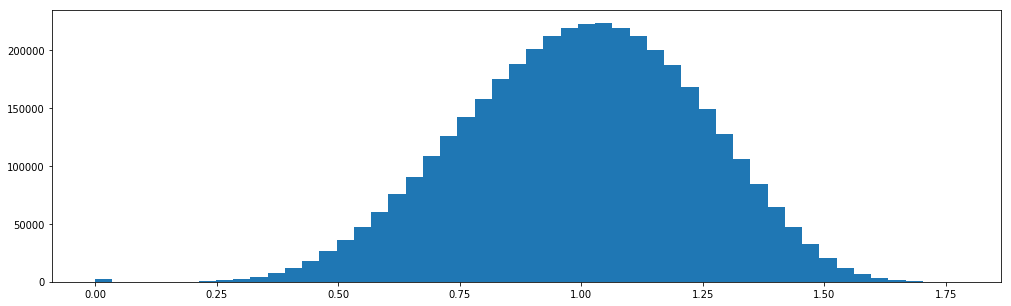

In [20]:
plt.hist(distances.reshape(-1), bins=50);

In [21]:
print('{} distances equal exactly zero.'.format(np.sum(distances == 0)))

2000 distances equal exactly zero.


In [22]:
#print(np.where(features.duplicated(subset = None, keep = False)==True))

Why are some distances equal to zero? **Your answer here.** The 2000 distances of zero above are the diagonal elements of the matrix constructed above. Indeed, since the distances computed on the diagonal elements are between the same tracks, the distance is of course 0.

However, there were some times where we could notice that there were more than 2000 distances equal to zero (this phenomenon has happened not recently). This was due to the fact that some tracks were apparently the same (the same track twice in the list). 

### 3.2 Weighted adjacency matrix

From our distances, we want to compute edge weights. If the distance is short, which means the tracks are similar, we want a strong edge. The most widespread kernel for that task is the Gaussian kernel, defined as
$$\mathbf{W}(u,v) = \exp \left( \frac{-d^2(u, v)}{\sigma^2} \right),$$
where $\sigma$ is a parameter which controls the width of the kernel.

Bonus. Can you think of another suitable kernel? **Your answer here.** We could use $W(u, v) = \frac{1}{d(u, v)}$, however in this case we should be sure to not have the same track twice otherwise we would get infinity.

Compute below the weight of each edge.

Hints:
* At first, you can set the kernel width, $\sigma$, to the mean value of the distance. (It will preserve the distribution of distances.)
* Don't forget to set the diagonal to zero! We don't want self-connections.

In [23]:
kernel_width = distances.mean()

weights = np.exp(-(distances**2)/(kernel_width**2))
    
#fill the diagonal values to zero, i.e. no self-connections
np.fill_diagonal(weights, 0) 

So we just created a fully connected graph. For our algorithms to be more efficient, we want to sparsify it. There are two main ways to sparsify a graph: i) thresholding all the weights smaller than an $\epsilon$, and ii) keep the $k$ strongest edges for each node. Implement below the second option. You can start with $k=100$.

Hints:
* You can use `np.argsort` to sort the weights.
* Be sure that your weight matrix stays symmetric.
* Look at both the sparsity pattern and the weight distribution as an indication of correctness.

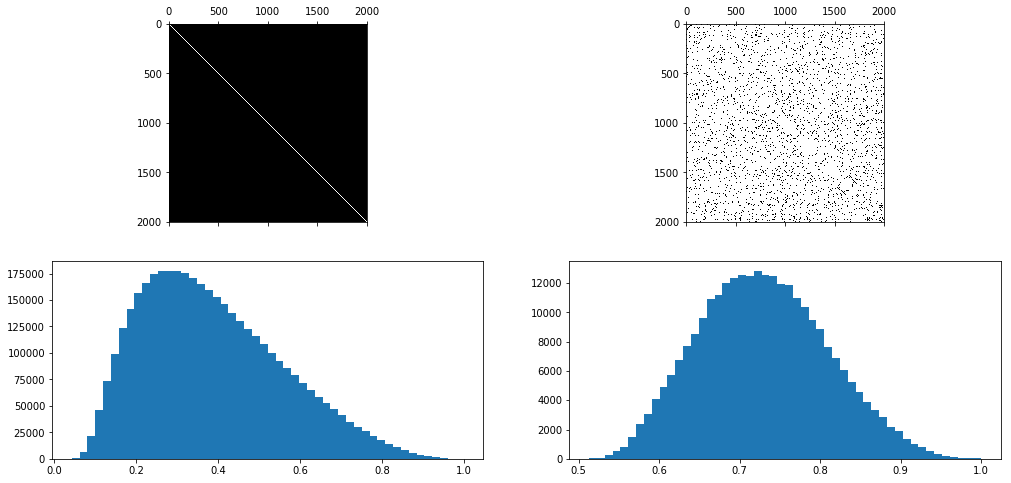

In [24]:
fix, axes = plt.subplots(2, 2, figsize=(17, 8))
def plot(weights, axes):
    axes[0].spy(weights)
    axes[1].hist(weights[weights > 0].reshape(-1), bins=50);
plot(weights, axes[:, 0])

NEIGHBORS = 100

#sort the order of the weights
sort_order = np.argsort(weights, axis = 1)

#declaration of a sorted weight matrix
sorted_weights = np.zeros((len(weights), len(weights)))

for i in range (0, len(weights)):  
    for j in range(0, len(weights)):
        if (j >= len(weights) - NEIGHBORS):
            #copy the k strongest edges for each node
            sorted_weights[i, sort_order[i,j]] = weights[i,sort_order[i,j]]
        else:
            #set the other edges to zero
            sorted_weights[i, sort_order[i,j]] = 0

#ensure the matrix is symmetric
bigger = sorted_weights.transpose() > sorted_weights
sorted_weights = sorted_weights - sorted_weights*bigger + sorted_weights.transpose()*bigger

plot(sorted_weights, axes[:, 1])

### 3.3 Bonus: visualize the adjacency matrix

Can you think of a way to observe if the two genres form clusters in the graph we created? You should only use the weight matrix `weights` and the genre labels `tracks['genre']`.

In [25]:
# Your code here.

### 3.4 Degrees

Compute below the degree vector.

Hints:
* Again, looking at the degree distribution will help you identify any mistake.

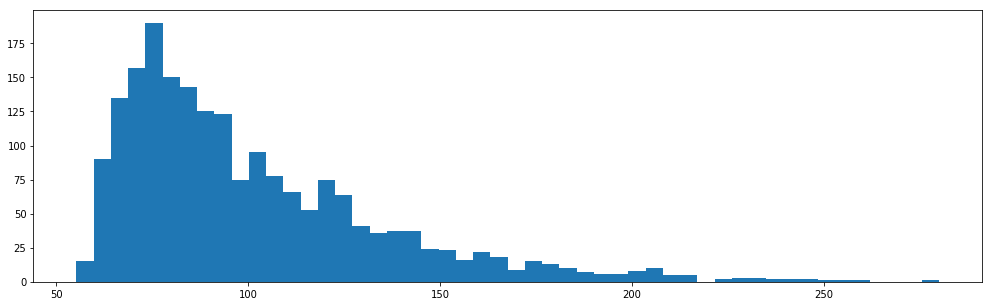

In [26]:
degrees = np.zeros(len(sorted_weights)) 

#reminder: the degrees of a node for a weighted graph are the sum of its weights

for i in range(0, len(sorted_weights)):
    degrees[i] = sum(sorted_weights[i])

plt.hist(degrees, bins=50);

### 3.5 Graph Laplacian

We will later need the Fiedler vector. Shall we compute the combinatorial or the normalized Laplacian? **Your answer here.** Both the normalized and non normalized Laplacian give us easy access to the Fiedler vector F (the eigenvector associated to the algebraic connectivity $\lambda_{2}$). However, when we use the normalized Laplacian, we have $0 = \lambda_1 \leq \lambda_2 \leq ... \leq \lambda_N \leq 2$. As we later wish to do clustering after having done a PCA (projection of the data on its prinicpal eigenvectors, where the eigenvalues represent the spread of the data along their corresponding axis/eigenvector), it might be wise to do normalization to have the condition above such that all the features would have the same importance when trying to separate the data. Indeed, if for example, the eigenvalues did not have the same range the clustering could be slightly biased in favor of the components along the eigenvector with the larger eigenvalue.

Implement your choice below. 

Hints:
* Compare the sparsity pattern of the Laplacian to the one of the weight matrix.

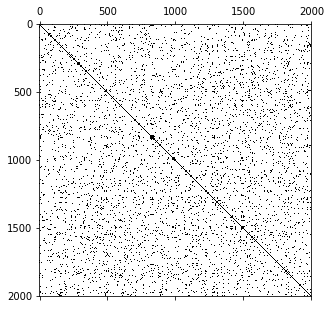

In [27]:
#reminder: L = D - W for weighted graphs
laplacian = np.diag(degrees) - sorted_weights 

#computation of the normalized Laplacian
laplacian_norm = np.linalg.inv(np.sqrt(np.diag(degrees)))@laplacian@np.linalg.inv(np.sqrt(np.diag(degrees)))

plt.spy(laplacian_norm);

For efficient storage and computation, we can store this sparse matrix in a [compressed sparse row (CSR)](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29) format.

In [28]:
laplacian_norm = sparse.csr_matrix(laplacian_norm)

Compute the number of remaining edges in the graph.

In [29]:
print('To compute the number of remaining edges in the graph, we first compute the number of non zeros elements in the graph, which we then substract by the number of diagonal elements. We then divide by two otherwise the edges will be counted twice (symmetric  matrix)')
print('The number of remaining edges is then equal to: {}'.format(int((np.sum(laplacian_norm != 0)-laplacian_norm.shape[0])/2)))

To compute the number of remaining edges in the graph, we first compute the number of non zeros elements in the graph, which we then substract by the number of diagonal elements. We then divide by two otherwise the edges will be counted twice (symmetric  matrix)
The number of remaining edges is then equal to: 138734


## 4 Eigendecomposition of the graph Laplacian

The whole point of spectral graph theory is to compute the eigendecomposition of the Laplacian. We however don't need the full eigendecomposition (a.k.a. the graph Fourier basis) here. Compute the 10 eigenvectors with the smallest eigenvalues with one of the following functions: `np.linalg.eig`, `np.linalg.eigh`, `sparse.linalg.eigs`, `sparse.linalg.eigsh`. Justify your choice.

**Your answer here.** By looking at the documentation, it would seem that the first two options are unable to return only a selected number of eigenvectors and values, thus we shall not use one of these two. The difference between the last two is that `sparse.linalg.eigsh` can only be used for real symmetric square matrices or complex hermitian matrices whereas `sparse.linalg.eigs` cannot. By definition our matrix L is real, symmetric and positive semi-definite, thus we can use `sparse.linalg.eigsh'.

In [30]:
eigenvalues, eigenvectors =  sparse.linalg.eigsh(laplacian_norm, k = 10, which = 'SM') 

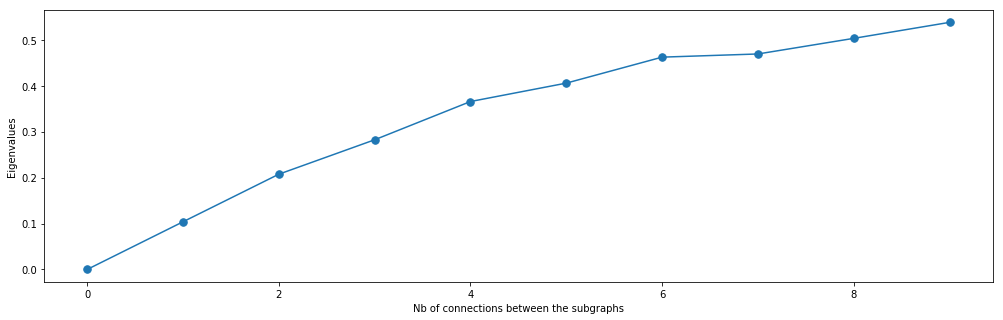

In [31]:
plt.plot(eigenvalues, '.-', markersize=15);
plt.xlabel('Nb of connections between the subgraphs')
plt.ylabel('Eigenvalues')
plt.show()

Why can we diagonalize the graph Laplacian in the first place? **Your answer here.** Because the Laplacian matrix is symmetric and positive semi-definite

Why are all the eigenvalues real? **Your answer here.** Because the matrix L or $L_{norm}$ is real, symmetric and positive semi-definite, thus the eigenvalues and eigenvectors are real values

Why are all the eigenvalues non-negative? **Your answer here.** Because the matrix is positive semi-definite 

### 4.1 Connectedness

Is the graph connected? Justify. Knowing how we built the graph, can we ensure it is connected?  

In [32]:
print('The second smallest eigenvalue is: {}'.format(eigenvalues[1]))

The second smallest eigenvalue is: 0.10384845076057635


**Your answer here.**
The algebraic connectivity of a graph G is the second-smallest eigenvalue $\lambda_{2}$ of its Laplacian matrix. This eigenvalue is greater than 0 if and only if G is a connected graph. Since $\lambda_{2} > 0$ (see cell above), we can see that the graph is connected.

### 4.2 Eigenvector question

What do you expect as the result of the below computation? Justify. Do you get the value you expected? If not, why?

Note that `x @ y` (introduced in Python 3.5) is equivalent to `np.matmul(x, y)`. You should prefer the former as it makes it easier to read formulas.

In [33]:
np.sum(laplacian @ (2 * eigenvectors[:, 0]))

-1.2789769243681803e-13

**Your answer here.** 

From the equation $L_{norm}\cdot f = \lambda \cdot f$, if we use $\lambda_{1} = 0$, we have $L_{norm}\cdot f = 0$. We would therefore expect the trivial answer where $f$ would be a vector of zeros. However, under more consideration of the formula, we realize that this condition does not necessarily impose that the vector $f$ is a vector of zeros. 

## 5 Visualization and clustering

Finally, let's use the data and graph we prepared. When [exploring data](https://en.wikipedia.org/wiki/Exploratory_data_analysis), it's often useful to visualize an entire dataset. Because for us humans it's hard to look at data in 140 dimensions, we need to somehow reduce the dimensionality to 2 or 3 and visualize the data in this more familiar space. While such a reduction will obviously be destructive, many algorithms have been developed to preserve certain properties.

### 5.1 Principal component analysis (PCA)

[PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) is a standard algorithm to reduce the dimensionality of a dataset. It computes the axes of principal variance and project the data on them. It does only use the features we computed, not the graph. We show it here for comparison. (We use [scikit-learn](http://scikit-learn.org), a very convenient library for Machine Learning.)

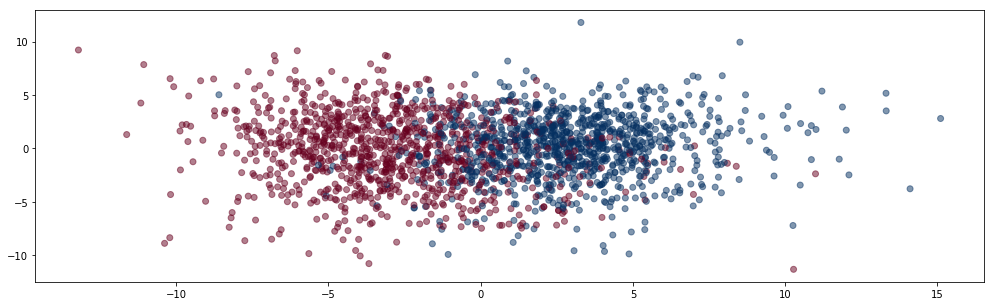

In [34]:
features_pca = decomposition.PCA(n_components=2).fit_transform(features)
genres = preprocessing.LabelEncoder().fit_transform(tracks['genre'])
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=genres, cmap='RdBu', alpha=0.5);

### 5.2 Graph embedding

Instead of using the features directly, we can try to visualize our similarity graph. That graph is embedded in an ambiant space of 140 dimensions (the number of features, that is the number of MFCCs times the number of summary statistics) at first, i.e. each node has a position in an 140-dimensional Euclidean space. Because we cannot visualize such an high-dimensional space, we want to embed the graph in a 2D space.

One way to embed a graph is to use the value of the eigenvectors as coordinates. For the below plot, use the value of the second eigenvector as the x coordinate of a node, and the value of the third eigenvector as the y coordinate. The color is indicated by the genre.

Why don't we use the first eigenvector? **Your answer here.** In a principal component analysis, we project the data along a certain number of dimensions (eigenvectors) where their correponding eigenvalues give an indication of the spread (variance) along that axis/dimension. Since $\lambda_{1} = 0$, this shows us that the spread of information will be very small along this dimension and that projecting the data on this axis would not give us much information nor help us to better separate the two classes.

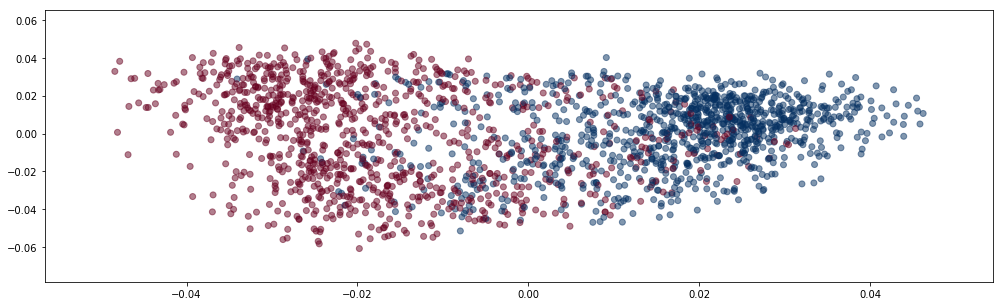

In [35]:
x = eigenvectors[:, 1] 
y = eigenvectors[:, 2] 
plt.scatter(x, y, c=genres, cmap='RdBu', alpha=0.5);

See how well this plot summarizes 2GB of data and 2000 tracks! We could now design a playlist generator as a random walk on this similarity graph and visualize its trajectory as it hops from track to track. :)

### 5.3 Clustering

Note how we did not try to build a machine to recognize the musical genre given a track (that would have been a [classification problem](https://en.wikipedia.org/wiki/Statistical_classification)). We did merely try to visualize the data, by means of PCA and a graph embedding algorithm. What does it tell us that genre clearly appears in our visualization?

**Your answer here.** From the plot above, we can see that just projecting the data along the second and thrid eigenvectors already separates the data well. A separation could for example be around 0 on the x axis (eigenvector corresponding to $\lambda_{2}$) and we could already predict the genre relatively well.

As such, we can try to cluster the tracks with the Fiedler vector, and look if the (unsupervised) clustering agrees with the *ground truth* genre categorization. Reproduce below the above scatter plot, but with the sign of the Fiedler vector as the color instead of the genre.

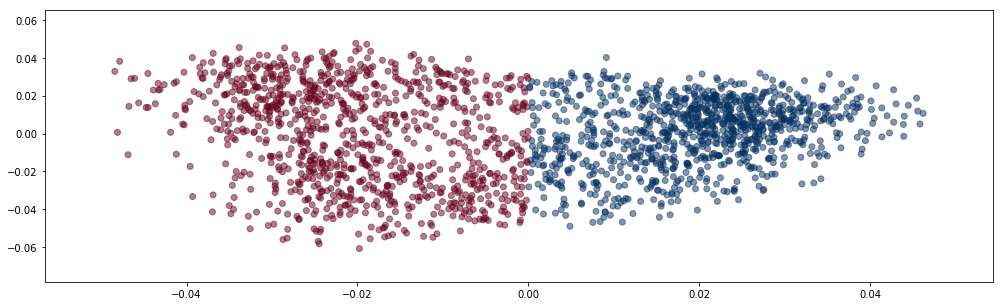

In [36]:
labels = eigenvectors[:, 1]/np.abs(eigenvectors[:, 1]) 

for i in range (0, len(labels)):
    if labels[i] < 0:
        labels[i] = 0

plt.scatter(x, y, c=labels, cmap='RdBu', alpha=0.5);

### 5.4 Error rate

How many tracks were wrongly categorized by the Fiedler vector, according to the Rock / Hip-Hop ground truth?

In [37]:
err = np.sum(genres.astype(int) != labels.astype(int))

print('{} errors ({:.2%})'.format(err, err/len(labels)))

277 errors (13.85%)


Tune some parameters (e.g. `kernel_width`, `NEIGHBORS`), discard some features (section 2.4), change the distance metric (section 3.1) to get less errors. You should get an error rate below 15% (i.e. less than 300 errors in total). Try to understand the effect of each parameter. After data cleaning, parameter tuning is the other dirty work of a data scientist! Be aware that tuning the parameters on a specific dataset will lead to [overfitting](https://en.wikipedia.org/wiki/Overfitting).

## 6 Conclusion

Among other things, this assignment showed us that a graph can be useful for e.g. visualization or clustering, even when there is none in the original data. One of the design goal of this assignment, while dealing with real data, was to follow the complete Data Science process, from data acquisition to interpretation of the results. The exploitation of the data showed us that a machine can discern musical genres by looking at pairwise distances between spectral features extracted from audio recordings.

### 6.1 Bonus

What is the name of the technique we used to visualize the data in the last two plots? What does it try to preserve when reducing the dimensionality (of the ambiant space) from 140 to 2? 

**Your answer here.**

**Graph embedding** tries to preserve the properties of the network and the structure of the graph.